# 2. Random Forest Model Interpretation

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [8]:
set_plot_sizes(12,14,16)

## 2.1 Notes and Tips for very large datasets

In order to limit the amount of space that it takes up when you read in, we create a dictionary for each column name to the data type of that column. We can then assign the dictionary to `dtype` when reading the csv file. 

If you run a line of code that takes quite a long time, you can put `%prun` in front. This will run a profiler and tells you which lines of code took the most time.

## 2.2 Continuation from previous notebook

In [9]:
PATH = "data/bulldozers/"

df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [10]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [11]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [12]:
df_raw

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,...,23,3,204,False,False,False,False,False,False,1248307200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401120,6333336,9.259131,1840702,21439,149,1.0,2005,NaN,NaN,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401121,6333337,9.305651,1830472,21439,149,1.0,2005,NaN,NaN,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401122,6333338,9.350102,1887659,21439,149,1.0,2005,NaN,NaN,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401123,6333341,9.104980,1903570,21435,149,2.0,2005,NaN,NaN,30NX,...,25,1,298,False,False,False,False,False,False,1319500800


## 2.3 Confidence based on tree variance

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

In [13]:
set_rf_samples(50000)

In [14]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20553127895236964, 0.24773982689094895, 0.9117142368350327, 0.8903926611735399, 0.894785247943287]


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the __standard deviation__ of predictions, instead of just the mean. This tells us the *relative* confidence of predictions - that is, for rows where the trees give very different results, we want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [15]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 1.53 s, sys: 109 ms, total: 1.64 s
Wall time: 1.65 s


(9.35424336973659, 0.3486735773372404)

This is how to do it for one observation. This takes quite a while and specifically, it is not taking advantage of the fact that my computer has lots of cores in it. We use the `parellel_trees` to take the random forest `m` and call it on every tree in parallel.

In [16]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 93.8 ms, sys: 656 ms, total: 750 ms
Wall time: 1.22 s


(9.35424336973659, 0.3486735773372404)

## 2.4 Plotting

We will first create a copy of the data and add the standard deviation of the predictions and predictions themselves (the mean) as new columns:

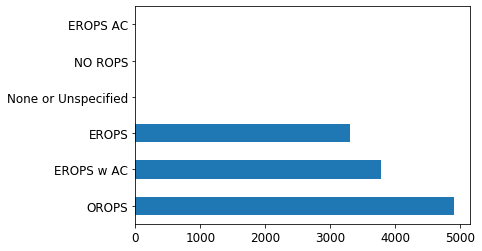

In [17]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

We will often find ourselves looking at data that we are not that familiar with and one has to figure out which bits to study more carefully, which bits seem to matter, and so forth. In this case, we know that `EROPS AC`, `NO ROPS`, and `None or Unspecified` are unimportant because they basically do not exist. So we will focus on `OROPS`, `EROPS w AC`, and `OROPS`. Below we take our data frame, grouped by `Enclosure`, then took average of 3 fields.

In [18]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure').mean() 
enc_summ

,SalePrice,pred,pred_std
Enclosure,,,
EROPS,9.849178,9.843357,0.273886
EROPS AC,NaN,NaN,NaN
EROPS w AC,10.623971,10.578125,0.264053
NO ROPS,NaN,NaN,NaN
None or Unspecified,NaN,NaN,NaN
OROPS,9.682064,9.687525,0.220740


In [19]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean() 
# When we use index=False, we indicate to groupby that we don't want to set the column ID as index
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.843357,0.273886
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.578125,0.264053
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.687525,0.220740


We learn that the prediction and the sale price are close to each other on average and that the SD varies a little.

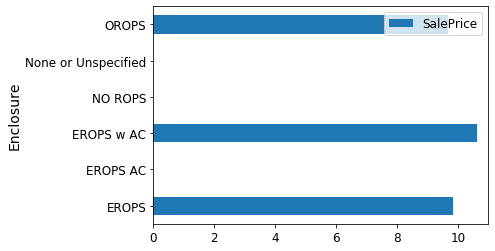

In [20]:
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

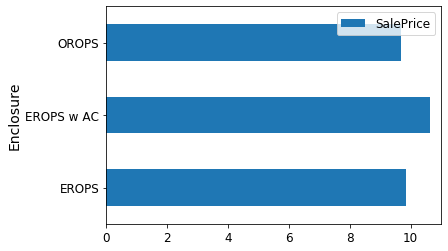

In [21]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

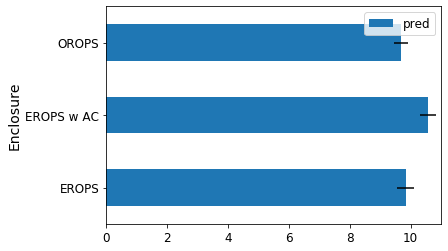

In [22]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', xlim=(0,11));

We used the standard deviation of prediction for the error bars above. This will tell us if there is some groups or some rows that we are not very confident of at all. We could do something similar for `ProductSize`:

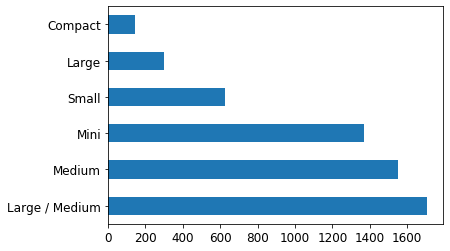

In [23]:
raw_valid.ProductSize.value_counts().plot.barh();

In [24]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby('ProductSize').mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.867143,0.344399
Large,10.470589,10.389696,0.350883
Large / Medium,10.691871,10.647710,0.298587
Medium,10.681511,10.627523,0.282022
Mini,9.535147,9.566857,0.251150
Small,10.324448,10.322288,0.302399


As expected, on average, when we are predicting something that is a bigger number, the standard deviation would be higher. Let us sort by the ratio of the standard deviation of the predictions to the predictions themselves.

In [25]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Compact           0.034904
Large             0.033772
Small             0.029296
Large / Medium    0.028042
Medium            0.026537
Mini              0.026252
dtype: float64

What this tells us is that product size `Large` and `Compact`, our predictions are less accurate (relatively speaking as a ratio of the total price). These are the smallest groups in the histogram, so as expected, in small groups we are doing less well.

We can use this confidence interval for two main purposes:
- We can look at the average confidence interval by group to find out if there are groups we do not seem to have confidence about.
- Perhaps more importantly, we can look at them for specific rows. When we put it in production, we might always want to see the confidence interval.

## 2.5 Feature Importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importance*.

Jeremy suggests: "_I always look at feature importance first in practice. Whether I’m working on a Kaggle competition or a real world project, I build a random forest as fast as I can, trying to get it to the point that is significantly better than random but doesn’t have to be much better than that. And the next thing I do is to plot the feature importance._"

In [26]:
fi = rf_feat_importance(m, df_trn); fi[:10] # in descending order by default

,cols,imp
5,YearMade,0.179007
37,Coupler_System,0.117940
13,ProductSize,0.101226
14,fiProductClassDesc,0.090943
2,ModelID,0.053885
63,saleElapsed,0.048795
10,fiSecondaryDesc,0.044563
39,Hydraulics_Flow,0.037559
38,Grouser_Tracks,0.035873
8,fiModelDesc,0.032576


In [27]:
fi[:5].sort_values(by='imp', ascending=True)

,cols,imp
2,ModelID,0.053885
14,fiProductClassDesc,0.090943
13,ProductSize,0.101226
37,Coupler_System,0.117940
5,YearMade,0.179007


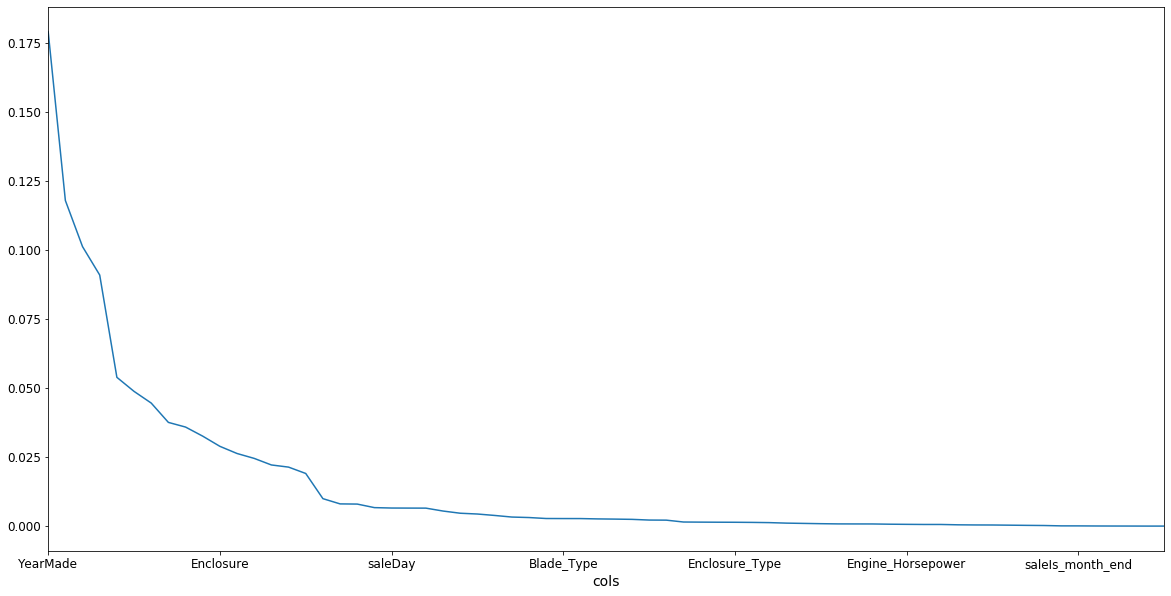

In [28]:
fi.plot('cols', 'imp', figsize=(20,10), legend=False);

In [29]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

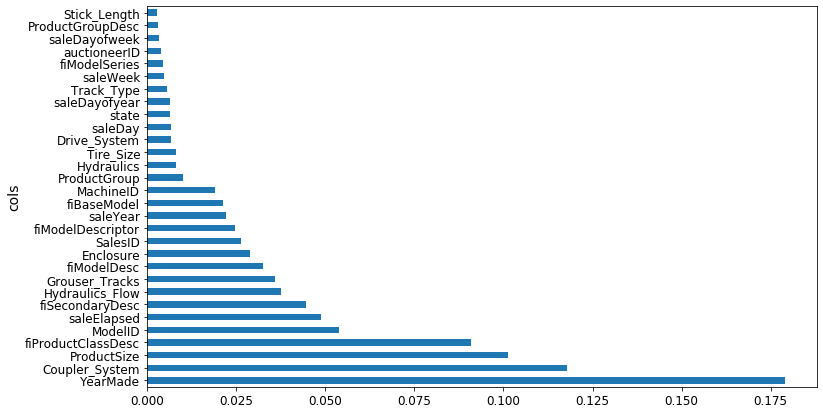

In [30]:
plot_fi(fi[:30]);

"_The most important thing to do with this is to now sit down with your client, your data dictionary, or whatever your source of information is and say to then “okay, tell me about `YearMade`. What does that mean? Where does it come from?” Plot lots of things like histogram of `YearMade` and scatter plot of `YearMade` against `price` and learn everything you can because `YearMade` and `Coupler-System` are the things that matter. What will often happen in real-world projects is that you sit with the the client and you’ll say “it turns out the `Coupler-System` is the second most important thing” and they might say “that makes no sense.” That doesn’t mean that there is a problem with your model, it means there is a problem with their understanding of the data they gave you. Also, one of the key things you will find here is __data leakage__ problems and that is a serious problem you need to deal with_"

In [31]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

24

In [32]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [33]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2069697920034875, 0.24687613859546284, 0.9104740882760913, 0.891155570877142, 0.8940570791570496]


The validation *R²* has increased from 0.8919 to 0.8925 but did not really change much. When deciding what to split on, there are fewer things to worry about trying, hence the improvement. 

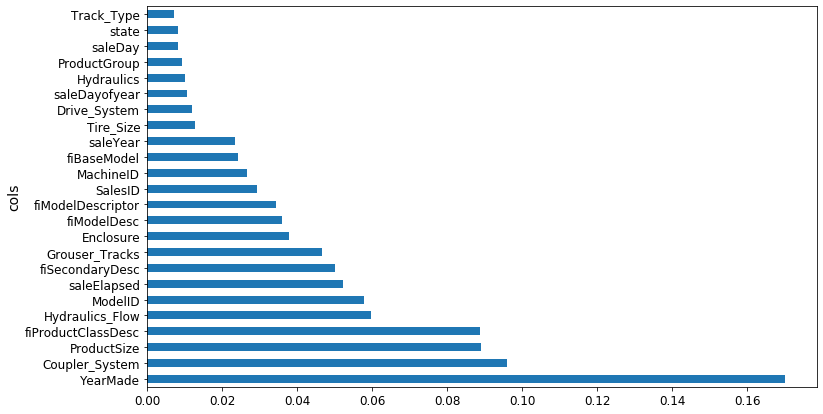

In [34]:
fi = rf_feat_importance(m, df_keep); plot_fi(fi);

Essentially, after removing redundant columns, we are removing sources of collinearity. Collinearity does not make our random forests less predictive, but if we have column A, which is a little bit related to a column B, and B is a strong driver of the independent variable, what happens is that the importance is going to be split between A and B. By removing some of those columns with very little impact, it makes our feature importance plot clearer. `YearMade` was close to `Coupler_System` previously, no longer the case.   

## 2.6 One-hot encoding

"After reading a dataset, it is often good to first check if a column actually contains meaningful categorical data. When working with data that was input by humans (say, users on a website), there might not be a fixed set of categories, and differences in spelling and capitalization might require preprocessing. For example, it might be that some people specified gender as “male” and some as “man” and we might want to represent these two inputs using the same category. A good way to check the contents of a column is using the `value_counts` function of a pandas series, to show us what the unique values are and how often they appear"

By far the most common way to represent categorical variables is using one-hot-encoding or one-out-of-N encoding, also known as dummy variables. So we can do one-hot-encoding easily enough and the way we do it is we pass one extra parameter to `proc_df` which is what is the max number of categories (`max_n_cat`). For example, the column **ProductSize** which has 6 categories:

* Large
* Large / Medium
* Medium
* Compact
* Small
* Mini

gets turned into 6 new columns:

* ProductSize_Large
* ProductSize_Large / Medium
* ProductSize_Medium
* ProductSize_Compact
* ProductSize_Small
* ProductSize_Mini

and the column **ProductSize** gets removed.

It will only happen to columns whose number of categories is no bigger than the value of the `max_n_cat` argument.

Now some of these new columns may prove to have more important features than in the earlier situation, where all categories were in one column.

In [35]:
df_raw

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,...,23,3,204,False,False,False,False,False,False,1248307200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401120,6333336,9.259131,1840702,21439,149,1.0,2005,NaN,NaN,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401121,6333337,9.305651,1830472,21439,149,1.0,2005,NaN,NaN,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401122,6333338,9.350102,1887659,21439,149,1.0,2005,NaN,NaN,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401123,6333341,9.104980,1903570,21435,149,2.0,2005,NaN,NaN,30NX,...,25,1,298,False,False,False,False,False,False,1319500800


In [36]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 65 columns):
SalesID                     401125 non-null int64
SalePrice                   401125 non-null float64
MachineID                   401125 non-null int64
ModelID                     401125 non-null int64
datasource                  401125 non-null int64
auctioneerID                380989 non-null float64
YearMade                    401125 non-null int64
MachineHoursCurrentMeter    142765 non-null float64
UsageBand                   69639 non-null category
fiModelDesc                 401125 non-null category
fiBaseModel                 401125 non-null category
fiSecondaryDesc             263934 non-null category
fiModelSeries               56908 non-null category
fiModelDescriptor           71919 non-null category
ProductSize                 190350 non-null category
fiProductClassDesc          401125 non-null category
state                       401125 non-null category
ProductGr

In [37]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

In [38]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20755045292778984, 0.2541524173705806, 0.909971047519446, 0.8846449893320256, 0.8922310472849087]


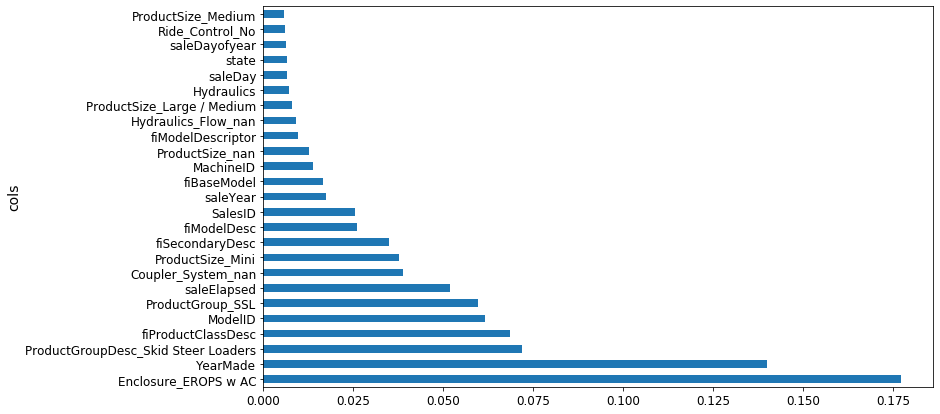

In [39]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

After running the random forest as per usual, we can see what happens to the R² of the validation set and to the RMSE of the validation set. In this case, we find it gets a little bit worse. This isn’t always the case and it’s going to depend on our dataset. It depends on if we have a dataset where single categories tend to be quite important or not. In this particular case, it did not make it more predictive. However, what it did do is that we now have different features. `proc_df` puts the name of the variable, an underscore, and the level name. So interestingly, it turns out that before, it said that `Enclosure` was somewhat important. When we use one-hot-encoding, it actually says `Enclosure_EROPS w AC` is the most important thing. So for at least the purpose of interpreting the model, one should always try one-hot-encoding. One can try making that number as high as you can so that it doesn’t take forever to compute and the feature importance doesn’t include really tiny levels that aren’t interesting. Now we need to find out more about `Enclosure_EROPS w AC` and why it is important.

__NOTE__: "If you have actually made an effort to turn your ordinal variables into proper ordinals, using `proc_df` can destroy that. The simple way to avoid that is if we know that we always want to use the codes for `usage band`, you could just go ahead and replace it:"

#`df_raw.UsageBand.cat.set_categories(['High', 'Medium','Low']),ordered=True, inplace=True`
#`df_raw.UsageBand = df_raw.UsageBand.cat.codes`


## 2.7 Removing redundant features

### 2.7.1 Hierarchical clustering and dendrograms

Agglomerative clustering refers to a collection of clustering algorithms that all build upon the same principle; the algorithm begins by declaring each point its own cluster, then merges the two most similar clusters until a stopping criterion (number of clusters in scikit-learn) is satisfied. scikit-learn uses the following three linkage criteria to measure the similarity between clusters:

- ward: Clusters chosen such that the variance within all clusters increases the least. These clusters tend to be relatively equally sized
- average: Clusters with the smallest average distance between all their points merged
- complete: Clusters with the smallest maximum distance between their points merged

Because of the way the algorithm works, agglomerative
clustering cannot make predictions for new data points. Therefore, agglomerative clustering has no _predict_ method. Agglomerative clustering __produces__ _hierarchical clustering_. Within the computation, one take a pair of objects which are say, the closest, delete them and replace them with the midpoint of the two, and repeat.  

In [40]:
from scipy.cluster import hierarchy as hc

In [41]:
??scipy.stats.spearmanr 
# Rank-order correlation matrix and p-value returned
# We require only the correlation matrix

Correlation is almost exactly the same as the R², but it’s between two variables rather than a variable and its prediction. Rank correlation essentially requires all plotted points to be replaced by their rank. Ordering is important for RFs, not linearity.

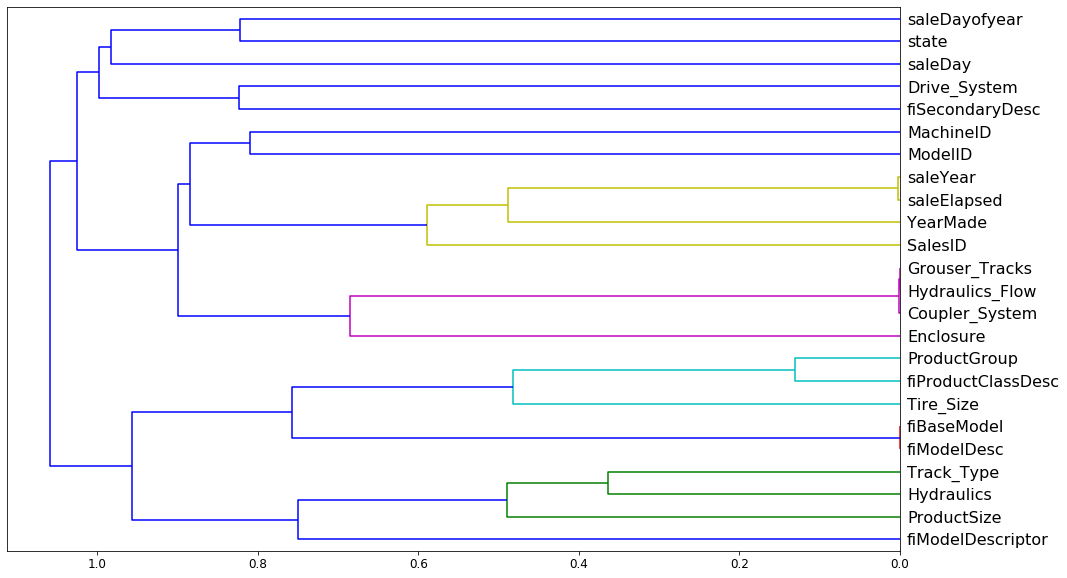

In [42]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4) # 4 d.p
corr_condensed = hc.distance.squareform(1-corr) #step 1
z = hc.linkage(corr_condensed, method='average') #step 2
fig = plt.figure(figsize=(16,10))
#step 3:
dendrogram = hc.dendrogram(z, labels=df_keep.columns,orientation='left', leaf_font_size=16)
plt.show()

### 2.7.2 Dendrogram Analysis

`saleYear` and `saleElapsed` are measuring basically the same thing (at least in terms of rank) which is not surprising because `saleElapsed` is the number of days since the first day in my dataset so obviously these two are nearly entirely correlated. `Grouser_Tracks`, `Hydraulics_Flow`, and `Coupler_System` all seem to be measuring the same thing. This is interesting because remember, `Coupler_System` is meant to be extremely important. So this rather supports our hypothesis that coupler system itself is not as relevant, but rather the vehicles which have these features are important. `ProductGroup` and `ProductGroupDesc` seem to be measuring the same thing, and so are `fiBaseModel` and `fiModelDesc`. We are going to look into those four groups that are very similar.

We want to see the effect of removing these features that rely on each other on the OOB-score. So we define a function to extract the OOB-score alone for rapid computations.

In [43]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [44]:
get_oob(df_keep)

0.8902521045602222

In [45]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.888916192763967
saleElapsed 0.8868313977880337
fiModelDesc 0.8881956169066532
fiBaseModel 0.8892147045688891
Grouser_Tracks 0.889908950496802
Coupler_System 0.8895345165777666


The OOB-core on the whole data frame is 0.89; so after dropping each one of these things, basically none of scores get much worse. Let us try one from each group for removal, simultaneously:

In [46]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.8885507542810968

We obtain a slight improvement, but almost meaningless. Now we drop these columns from our dataframe and run the full model again.

In [47]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [48]:
np.save('data/bulldozers/keep_cols.npy', np.array(df_keep.columns))
keep_cols = np.load('data/bulldozers/keep_cols.npy', allow_pickle=True)
df_keep = df_trn[keep_cols]

In [49]:
reset_rf_samples() # we use our whole bootstrapped sample

In [50]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12573746657119989, 0.2267821082528443, 0.966958158964539, 0.9081528783597317, 0.9086290295018357]


So we now got a model which is smaller and simpler, with a better score! So at this point, we have gotten rid of columns that either did not have good feature importance or were highly related to other variables, and the model didn’t get worse significantly when we removed them.

## 2.8 Partial dependence

This technique will help us infer how the important features relate to the dependant variable. As we are continuing interpretation, we will use `set_rf_samples` once again to speed things up.

In [51]:
from pdpbox import pdp
from plotnine import *

In [52]:
set_rf_samples(50000)

In [53]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, 
       max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

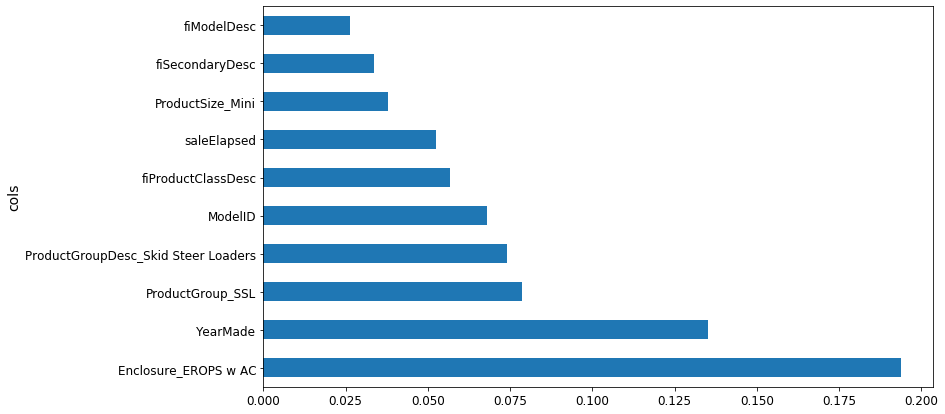

In [54]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]); # top 10 features

So one obvious thing we could do would be to plot `YearMade` against `saleElapsed` as they are both important. It also seems very likely that they are combined together to find how old was the product when it was sold.

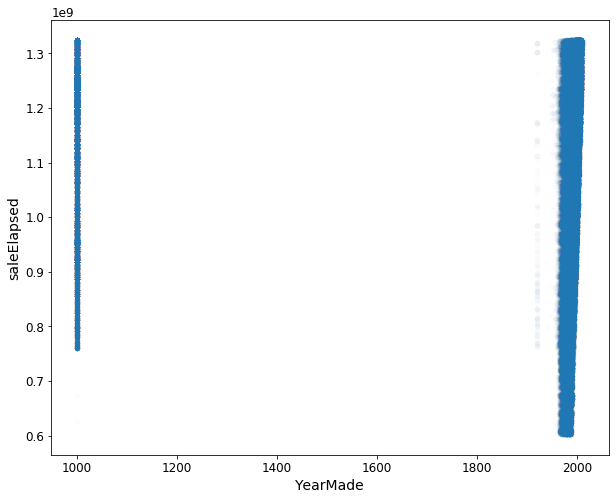

In [55]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

We see that `YearMade` has a lot of data for 1000. Here, one would go back to the client and (Jeremy) says: "Okay, I’m guessing that these bulldozers weren’t actually made in the year 1000 and they would presumably say to me “oh yes, they are ones where we don’t know where it was made”. Maybe “before 1986, we didn’t track that” or maybe “the things that are sold in Illinois, we don’t have that data provided”, etc — they will tell us some reason." So in order to understand this plot better, we will remove them from this interpretation section of the analysis. We will just use things where `YearMade` is greater than 1930.

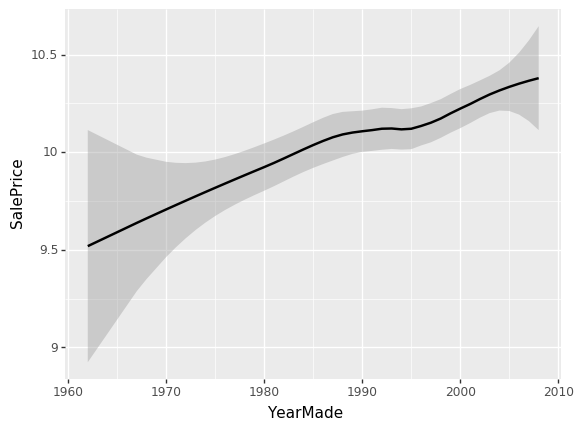

<ggplot: (8786680153706)>

In [56]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500) # 500 points from dataframe chosen
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, 
       method='loess')

We extract a sample from our data frame and plot `YearMade` against `SalePrice`. `aes` stands for “aesthetic” — this is the basic way to set up our columns in `ggplot`. “+” means adding chart elements, so we add a smoother to deal with the haphazard nature of the scatter plot. A smoother basically creates a little linear regression for every little subset of the graph. By adding standard error `se=True`, it also shows us the confidence interval of this smoother. `loess` stands for locally weighted regression which is this idea of doing lots of little mini regressions.

What we really want to be able to do is say “well, what’s the relationship between `SalePrice` and `YearMade` with all other things being equal. “All other things being equal” basically means if we sold something in 1990 vs. 1980 and it was exactly the same thing to exactly the same person in exactly the same auction so on and so forth, what would have been the difference in price?" To do that, we do something called a __partial dependence plot__.

In [57]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [58]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat) # pdp = partial dependence plot
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


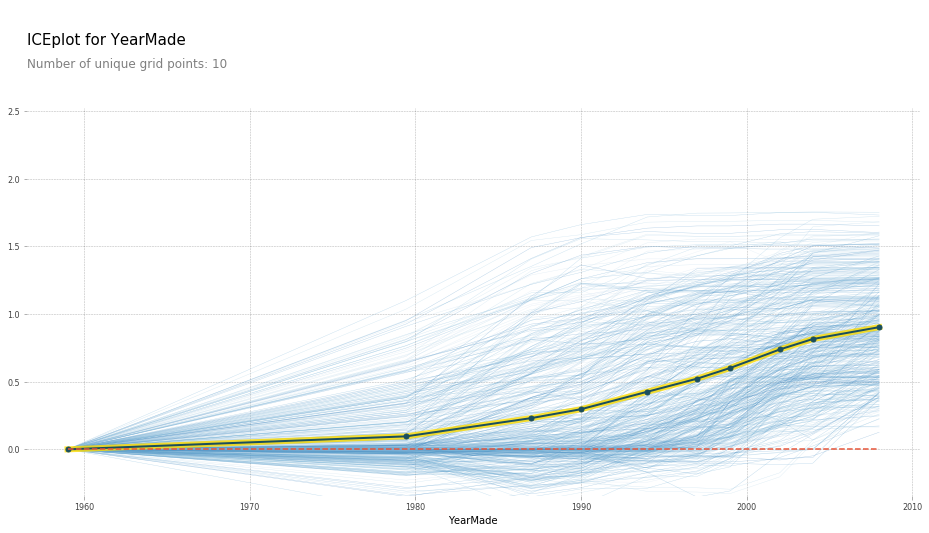

In [59]:
plot_pdp('YearMade')

To create these plots, what happens is this. Assuming a dataset of 500 auctions, we create a chart where we say if all other things are unchanged in 1960 (`YearMade`), what was the `saleprice` during auctions. In practise, the value 1960 is copied throughout all the rows down the `SaleYear` column. We are going to take our random forest, we are going to pass all this through our random forest to predict the sale price. That will tell us for everything that was auctioned, how much do we think it would have been sold for if that thing was made in 1960. And that’s what we are going to plot on the right. The same is then done for 1961 and so on. This is essentially the same as the process for feature importance where the columns were shuffled to see the effect on the saleprice, but instead the values are replaced with a constant value. 

We actually plot all 500 predictions of how much every one of those 500 auctions would have gone for if we replaced its `YearMade` with each of these different values. The dark line is the average which tells us how much would we have sold on average all of those auctions for if all of those products were actually made in 1985, 1990, 1993, etc. Post-1990, we have more data so we find a near-straight line. This relationship now makes sense as if the same kind of tractor was sold on the same date to the same person in the same auction house, more recent vehicles should be more expensive due to inflation and the fact that they are newer. 

We can use clusters within PDP which use cluster analysis and produce more clearly visible relationships:

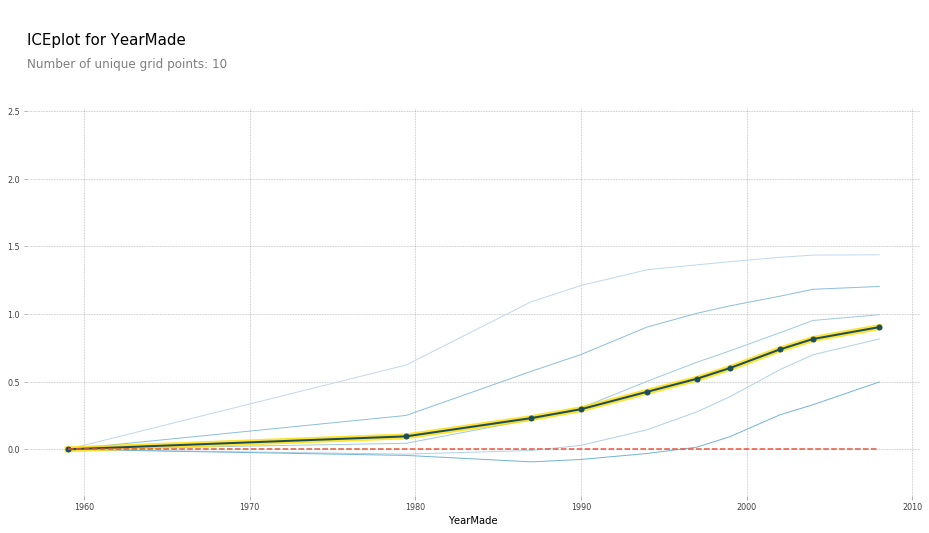

In [60]:
plot_pdp('YearMade', clusters=5)

Now we can see that some kinds of vehicles plataeu in their sale price after 1990. With some vehicles, it is the opposite. These patterns can be analysed in more detail. Note, the unexpected dip in the ggplot no longer really exists.

TypeError: clabel() got an unexpected keyword argument 'contour_label_fontsize'

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


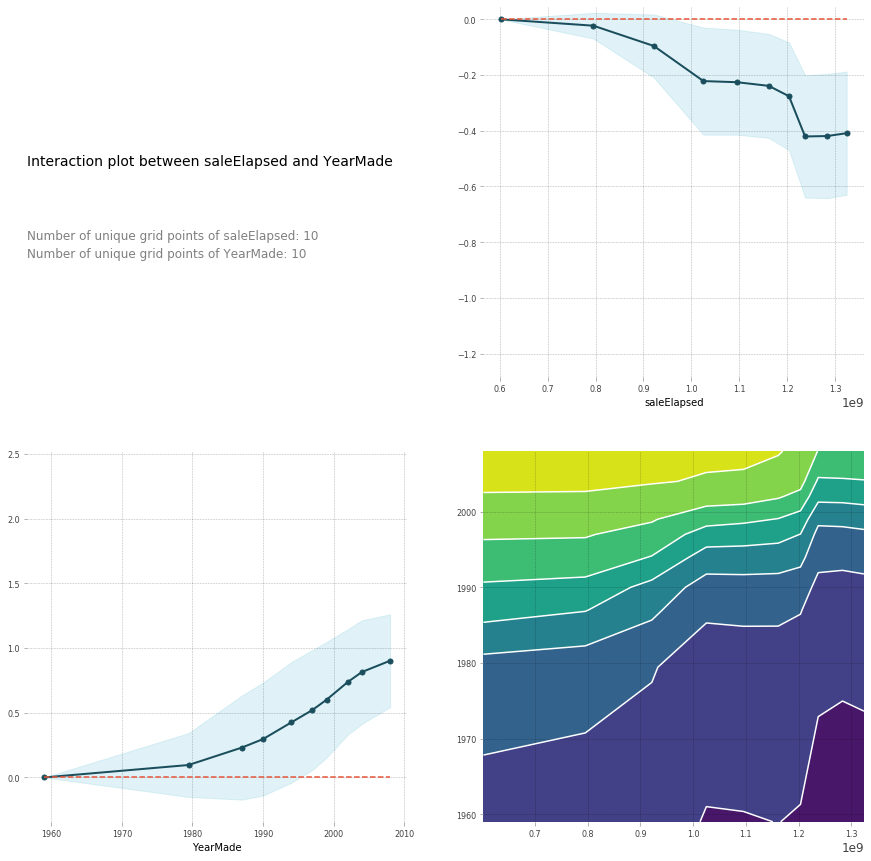

In [61]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, feats)
pdp.pdp_interact_plot(p, feats)

We can also produce a PDP interaction plot to see how `saleElapsed` and `YearMade` together, impact the sale price. We can see clearly that these two things are driving price together. We can also see that these are not simple diagonal lines so there is some interesting interaction going on; therefore we should perpahps put in some kind of interaction term and see what happens.

If we have one-hot-encoded variables, we can pass an array of them to `plot_pdp` and it will treat them as a category. The plot below shows us that on average, `Enclosure_EROPS w AC` drives the price up higher than the other two variables. Using a search engine, one can find that `EROPS` - _Enclosed Rollover Protective Structure_. Therefore `Enclosure_EROPS w AC` simply refers to the bulldozers being enclosed structures with _air-conditioning_, hence the greater sale price.

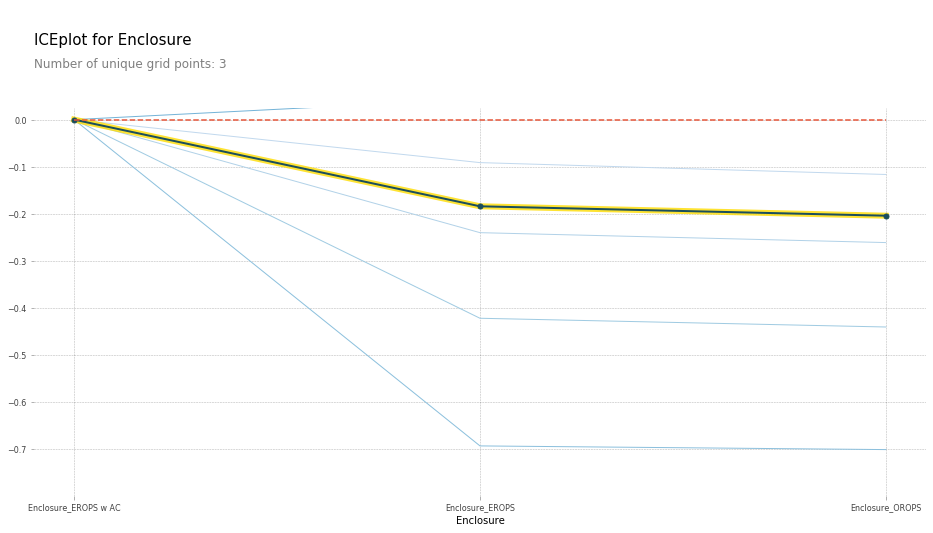

In [62]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

Looking at the above analysis, we seem to have some missing data before 1950, so we set everything before then to 1950. We also set `age` to be equal to `saleYear - YearMade`, and then run that through the random forest. We then find that `age` seems to be the most important feature.

In [63]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

In [65]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.20710860667646996, 0.24738376523078112, 0.9103539579169156, 0.8907074989285428]


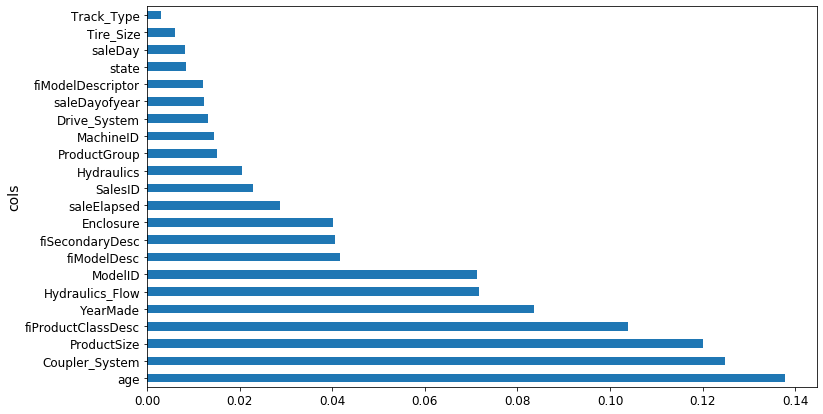

In [67]:
plot_fi(rf_feat_importance(m, df_keep));

But remember, of course a random forest can create an interaction through having multiple split points, so we shouldn’t assume that this is actually going to be a better result. And in practice, we find adding `age` made the score and RMSE a little worse.

## 2.9 Tree Interpreter

In [68]:
from treeinterpreter import treeinterpreter as ti

In [69]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [70]:
row = X_valid.values[None,0]; row

array([[      1999,          0,          5,         17,        665, 1284595200,          0,          0,
              3232,          1,    4364751,          0,    2300944,          4,         12,          0,
                 0,         16,         35,        259,          2,         11]])

In [71]:
prediction, bias, contributions = ti.predict(m, row)

In [72]:
prediction[0], bias[0]

(array([9.35456]), 10.105090887933812)

In [73]:
idxs = np.argsort(contributions[0]) #  argsort just tells you where each item would move to if it were sorted

In [74]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.51945853084269),
 ('age', 11, -0.15364587076324376),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.10289441867807629),
 ('fiModelDesc', 'KX1212', -0.08699526465079117),
 ('fiSecondaryDesc', nan, -0.062325033775479044),
 ('Enclosure', 'EROPS', -0.05965480871400959),
 ('SalesID', 4364751, -0.03401702814434544),
 ('fiModelDescriptor', nan, -0.014171609452329693),
 ('Tire_Size', nan, -0.010152882812657183),
 ('state', 'Ohio', -0.008998625670406168),
 ('saleDay', 16, -0.003443778824435473),
 ('saleElapsed', 1284595200, -0.0004108814320970211),
 ('saleDayofyear', 259, 0.0008468823587759911),
 ('ProductGroup', 'TEX', 0.008417274836890032),
 ('Track_Type', 'Steel', 0.01047695975850691),
 ('Drive_System', nan, 0.011069227928673486),
 ('Hydraulics', 'Standard', 0.011219489577030428),
 ('MachineID', 2300944, 0.01624232710167912),
 ('ModelID', 665, 0.029382300119785355),
 ('Hydraulics_Flow', nan, 0.031839620173786234),
 ('Coupler_

In [75]:
contributions[0].sum()

-0.7505350540249721

Waterfall plots can be used to plot these changes in the value of the log of the price, but can not be done through Python (Excel works). 

# 3. Revisiting some concepts

What we do is we train a model, check it against the validation set to see if it generalizes, and we do this a few times. Then when we finally have something we think will generalize successfully based on the validation set (at the end of the project), we check it against the test set; the remaining data become the training set. We do this to ensure we are not overfitting to the validation set. So if we try 50 different models against the validation set and then at the end of all that, we then check that against the test set and it has still generalized as well, we can say we have come up with generalizable model; else, we would have overfit to the validation set. 

The OOB score: this idea was to say every time we train a tree in a random forest, there are some rows that are held out anyway to create some of the randomness. So let us calculate our score for each tree based on those held out samples and therefore the forest by averaging the trees that for each row was not part of training. So the OOB score gives us something which is pretty similar to the validation score, but on average it’s not as good as the entire ensemble is not considered. The reason for this is that _every row is going to be using a subset of the trees to make its prediction, and with less trees, we know we get a less accurate prediction_. 

## 3.1 Temporal ordering in datasets

There may often exist temporal ordering in the data and as a result, we may find some lag between the data that we are building our model on and the data that it’s going to actually be used on in real life. In this case, once we have something that works well on the validation set, we cannot then go and just use that model on the test set because the test set is much farther in the future compared to the training set. We would then replicate building that model again but this time by combining the training and validation sets together and retraining the model. At that point, we have no way to test against a validation set, so we have to make sure we have a reproducible script or notebook that does exactly the same steps in exactly the same ways because if we get something wrong then we would encounter issues on the test set. In practice, Jeremy suggests the following:   "__I need to know if my validation set is a truly representative of the test set. So what I do is I build five different models on the training set, and I try to have them vary in how good I think they are. Then I score my five models on the validation set and then I also score them on the test set__." For example, in the _Groceries_ competition Jeremy was working on at the time, where his team were trying to predict the next two weeks of grocery sales, the possible validation sets that they came experimented with were a random sample over 4 years, the last month of data (July 15–August 15), the last 2 weeks (August 1–15) and the same day range but one month earlier (July 15–30). The test set in this competition was the 15th to the 30th of the August. "__I build 5 models, so there might be 1. just predict the average, 2. do some kind of simple group mean of the whole data set, 3. do some group mean over the last month of the data, 4. build a random forests of the whole thing, 5, build random forest from the last three weeks. On each of those, I calculate the validation score. Then I retrain the model on the training set + validation set and calculate the same thing on the test set. So each of these points now tells me how well did it go on the validation set and how well did it go in the test set. If the validation set is useful, we would say every time the validation score set improves, the test set score should also improve__". We do this for the various validation sets we have isolated and then compare.


## 3.2 Cross-validation

One way to assess generalization performance is to use a statistical method known as __cross-validation__. This method is generally considered more robust and stable than simply splitting data into a training and test set. Under _k-fold cross-validation_ (usually, k = 5 or 10), the dataset is split repeatedly into k equal parts and multiple models are trained. If k = 5 for example, the first fold is deemed the test set and the remaining folds the training set, the model is the evaluated on these; following this, the second fold is deemed the test set and folds 1, 3-5 are allocated to the training set, and so on. Finally, the average of the evaluated accuracies are calculated.

### 3.2.1 Advantages and disadvantages of cross-validation

Cross-validation allows one to access the entire dataset and use it in its entirety. Additionally, through this method, we are able to train on 80% of the data at a time, which is higher than say, the __train_test_split__ method which trains on 75% of the data. Another advantage is that we no longer need to worry about perhaps getting lucky or unlucky with our random selection of the training and test sets which would give us inaccurate results. We also acquire some information about how sensitive our model is with regards to the selection of training dataset. 

Disadvantages are few in number. The foremost disadvantage is computational power and time; if we are training a deep learning model which perhaps takes a day, carrying this out 5 times can become troublesome. Another disadvantage is the possibility of temporal ordering of data, as discussed above; in this case, cross_validation may produce inaccurate scores with high-variance amongst them. Essentially, any datasets with random sampling or random validation sets could pose issues. We recall that we want to have our validation set be as close to the test set as possible, and we cannot do that by randomly sampling different things.

# 4 Extrapolation

In [76]:
print_score(m)

[0.20710860667646996, 0.24738376523078112, 0.9103539579169156, 0.8907074989285428]


We can see here a rather large difference between the validation score and the OOB-score, which implies that we have not dealt temporal aspect of the data correctly. One way we deal with this is to try to avoid using time variables as predictors if there is something else we could use that could give us a better or stronger relationship, which would actually work in the future.

If we can figure out the difference between our validation set and our training set, then that tells us which predictors have a strong temporal component and therefore, may be irrelevant by the time I get to the future time period. We create a random forest where the dependent variable is _is it in the validation set_ (`is_valid`). We grab the whole data frame with the training and validation all together and create a new column called `is_valid` which is set to one and then for all of the stuff in the training set, it is set to zero. So we now have a new column which is _is this in the validation set or not_ and then we use that as the dependent variable and build a random forest. This is a random forest not to predict price but predict _is this in the validation set or not_. So if a variable were not time dependent, then it shouldn’t be possible to figure out if something is in the validation set or not.

In [77]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [78]:
df_ext[5:]

,YearMade,Coupler_System,ProductSize,fiProductClassDesc,ModelID,saleElapsed,fiSecondaryDesc,Hydraulics_Flow,fiModelDesc,Enclosure,...,ProductGroup,Hydraulics,Tire_Size,Drive_System,saleDay,state,saleDayofyear,Track_Type,age,is_valid
5,2004,0,0,2,4605,1229558400,57,0,493,6,...,1,0,0,2,18,3,353,0,4,0
6,1993,0,3,14,1937,1093478400,48,0,1453,1,...,4,12,0,0,26,9,239,2,11,0
7,2001,0,0,2,3539,1132185600,41,0,740,6,...,1,0,0,2,17,13,321,0,4,0
8,2008,0,5,17,36003,1251331200,62,0,779,1,...,4,4,0,0,27,44,239,1,1,0
9,1000,0,2,68,3883,1186617600,21,0,1771,3,...,6,1,17,0,9,9,221,0,57,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401120,2005,0,5,17,21439,1320192000,106,0,657,1,...,4,4,0,0,2,20,306,2,6,1
401121,2005,0,5,17,21439,1320192000,106,0,657,1,...,4,12,0,0,2,20,306,2,6,1
401122,2005,0,5,17,21439,1320192000,106,0,657,1,...,4,4,0,0,2,20,306,2,6,1
401123,2005,0,5,13,21435,1319500800,106,0,483,1,...,4,12,0,0,25,9,298,2,6,1


In [79]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9999900280461202

In this case, we can see we don’t have a random sample because the validation set can be predicted with a .9999 R².

In [80]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
10,SalesID,0.810506
5,saleElapsed,0.130042
12,MachineID,0.049486
0,YearMade,0.002787
19,saleDayofyear,0.001974
8,fiModelDesc,0.001287
9,Enclosure,0.001236
4,ModelID,0.000807
1,Coupler_System,0.000789
21,age,0.000489


So then if we look at feature importance, the top thing is `SalesID`. So this is really interesting. It tells us very clearly that `SalesID` is not a random identifier but probably it’s something that is set consecutively as time goes on — we just increase the `SalesID`. `saleElapsed` was the number of days since the first date in our dataset so not surprisingly that also is a good predictor. Interestingly `MachineID` — clearly each machine is being labeled with some consecutive identifier as well and then there’s a big drop in importance, so we stop here.

In [81]:
feats=['SalesID', 'saleElapsed', 'MachineID']

In [82]:
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,3.891250e+05,389125.000000
mean,1800.452485,1.084797e+06,1206.796148
std,595.627288,1.803913e+05,430.850552
min,1139.246000,6.009984e+05,0.000000
25%,1413.348000,9.666432e+05,1087.016000
50%,1632.093000,1.134605e+06,1273.859000
75%,2210.453000,1.234138e+06,1458.661000
max,4364.741000,1.325117e+06,2313.821000


In [83]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,1.200000e+04,12000.000000
mean,5786.967651,1.306609e+06,1578.049709
std,836.899608,2.497808e+04,589.497173
min,4364.751000,1.174522e+06,0.830000
25%,4408.580750,1.309219e+06,1271.225250
50%,6272.538500,1.316045e+06,1825.317000
75%,6291.792250,1.321402e+06,1907.858000
max,6333.342000,1.325203e+06,2486.330000


We can see for example, `SalesID` on average is 1.8 million in the training set and 5.8 million in the validation set (notice that the value is divided by 1000). So we can confirm they are very different, therefore we drop them.

In [84]:
x.drop(feats, axis=1, inplace=True)

In [85]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.978645060766594

In [86]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
18,age,0.235946
0,YearMade,0.184456
16,saleDayofyear,0.152715
4,ModelID,0.079479
7,fiModelDesc,0.064417
14,saleDay,0.059229
15,state,0.055323
3,fiProductClassDesc,0.032688
5,fiSecondaryDesc,0.023176
8,Enclosure,0.021407


In [87]:
set_rf_samples(50000)

In [88]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [89]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2078129984949352, 0.24820485118527483, 0.9097431352027887, 0.8899807943117728, 0.8931530177212477]


Now, we just go through each one of those features and drop each one, one at a time, retrain a new random forest, and print out the score.

In [90]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.2093392939785316, 0.24742647977001617, 0.9084124722070143, 0.8906697536718662, 0.8922153610892223]
saleElapsed
[0.21418936764946503, 0.25478327435158427, 0.9041194220018868, 0.8840716103142462, 0.8870484915589512]
MachineID
[0.207063466670477, 0.24572292831018758, 0.9103930309612897, 0.8921700662393068, 0.8947166571142061]
age
[0.20915735688160542, 0.24831302301489638, 0.9085716007453036, 0.8898848769915524, 0.8920914186060344]
YearMade
[0.20918203351526504, 0.25274314339904114, 0.9085500258101497, 0.8859207285092066, 0.8919582225522341]
saleDayofyear
[0.20874505437830698, 0.24392046225336514, 0.9089317028624395, 0.8937462068733341, 0.8929187223753419]


When we removed a time dependent variable, there were other variables that could find similar relationships without the time dependency. So removing it caused our validation to go up. We should remove `SalesID` for sure, but `saleElapsed` didn’t get better. `MachineID` did get better — 0.889 to 0.892 so it’s actually quite a bit better. `age` got a bit better. `YearMade` got worse, `saleDayofyear` got a bit better. So now we can say, let’s get rid of the three where we know that getting rid of it actually made it better. And as a result, we are now up to .915! So we got rid of three time dependent things and now as expected our validation is better than our OOB.

In [91]:
reset_rf_samples()

In [92]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1385885209574885, 0.21862440823842472, 0.959858892929554, 0.9146417961421327, 0.9090690734180181]


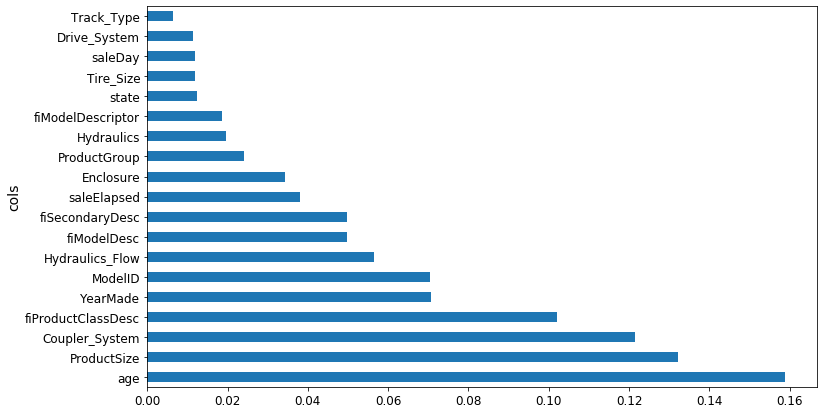

In [93]:
plot_fi(rf_feat_importance(m, X_train));

In [94]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

In [95]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 4min 44s, sys: 7.73 s, total: 4min 52s
Wall time: 44.4 s
[0.0801139610693921, 0.21146727359820633, 0.9865862182385425, 0.9201390805271051, 0.9145669876409067]


Note: This new RMSE of 0.211 would have landed us at the very top of the leaderboard in the Kaggle competition!